# Chapter 3 - Deep Q-learning
### Deep Reinforcement Learning *in Action*

상태 : 환경이 에이전트에 제공하는 정보  
정책 : 에이전트가 주어진 상태에 기초해서 도작을 선택하는 전략   
보상 : 동작을 취한 후 에이전트가 받는 신호, 피드백  
가치 : 시작 상태 S1에서 시작해서 정책에 따라 일련의 동작을 수행해서 얻은 보상들의 가중합, 기대보상  
가치함수 : 주어진 상태 S의 가치를 돌려주는 가치 함수  

Q학습 : 상태-동작 쌍의 현재 Q 가치와 향후 기대가치의 합으로 갱신(장기적인 평균 보상)  
초매개변수(hyperparameter)  
- 알파 : learning rate  
- 감마 : 할인 계수, 향후 보상들의 영향 감소율  
에피소드 : 게임 시작에서 최종 승리 또는 패배까지의 과정(여러 번의 동작으로 구성)  

##### Listing 3.1

In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static') 
#4*4 size grid board 생성
# mode : static, player, random

In [2]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.reward()

-1

In [19]:
# 3차 텐서로 표현, 4*4*4 : 플레이어, 목표, 구덩이, 벽
# 신경망에 입력할 때에는 4*4*4 = 64차원의 벡터로 입력 (0,1로 표현)
# 4*4에 0,1,2,3으로 표현하는것과 결과적으로 어떤 차이? 
game.board.render_np()

array([[[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

##### Listing 3.2  
Q 함수 역할을 신경망으로 대체  
입력 : 64, 출력 : 4(움직임 종류)  
감마 : 0.9, epsilon : 1 (초반에 무작위 진행)  

In [6]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

##### Listing 3.3

In [7]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [30]:
np.random.rand(1,64)/10

array([[0.05448263, 0.07746989, 0.03672575, 0.06140424, 0.08802859,
        0.08275285, 0.0868907 , 0.05690494, 0.07115881, 0.02067243,
        0.00827659, 0.01679108, 0.00890359, 0.04828864, 0.06749778,
        0.0402688 , 0.06356257, 0.09065099, 0.05422873, 0.02614314,
        0.04665235, 0.04474301, 0.02909964, 0.02841855, 0.03421962,
        0.09073583, 0.01015463, 0.07847417, 0.04331197, 0.01551099,
        0.03318073, 0.06982539, 0.05384161, 0.03767621, 0.00061099,
        0.02125578, 0.00600851, 0.00460263, 0.03349677, 0.05621019,
        0.09806896, 0.05815916, 0.04794922, 0.09541475, 0.05787819,
        0.07294074, 0.01724341, 0.08362901, 0.02252715, 0.08701595,
        0.08945607, 0.07056206, 0.01752535, 0.0067465 , 0.06662551,
        0.04794754, 0.03281157, 0.04256614, 0.04051265, 0.01220722,
        0.0258856 , 0.08726871, 0.05128181, 0.05808717]])

In [31]:
epochs = 1000
losses = [] #A
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C 각 epoch마다 새 게임 시작  
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D 노이즈 추가
    state1 = torch.from_numpy(state_).float() #E 넘파이배열 텐서로 변환
    status = 1 #F 게임 진행 플래그 
    while(status == 1): #G
        qval = model(state1) #H Q가치 예측
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I 엡실론 탐욕법 이용해 동작 선택 (처음엔 1로 랜덤)
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] #J 숫자->액션 문자로 변환
        game.makeMove(action) #K action 수행
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # action 수행 후 새로운 상태
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad(): # 새로운 상태에 대한 새로운 가치
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #M maxQ값 갱신
        if reward == -1: #N -1이 아니면 승리 또는 패배, 게임 끝
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O qval에서 현재 동작에 해당하는 성분만 갱신
        loss = loss_fn(X, Y) #P
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad() # 역전파 단계 전에, optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인) 갱신할 변수들에 대한 모든 변화도(gradient)를 0으로 만듬
        loss.backward() # 역전파 단계: 모델의 학습 가능한 모든 매개변수에 대해 손실의 변화도를 계산
        losses.append(loss.item())
        optimizer.step() # optimizer의 step 함수를 호출하면 매개변수가 갱신
        state1 = state2
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R 한 에피소드 끝날 때마다 엡실론 감소
        epsilon -= (1/epochs)

999 0.18810610473155975


Text(0, 0.5, 'Loss')

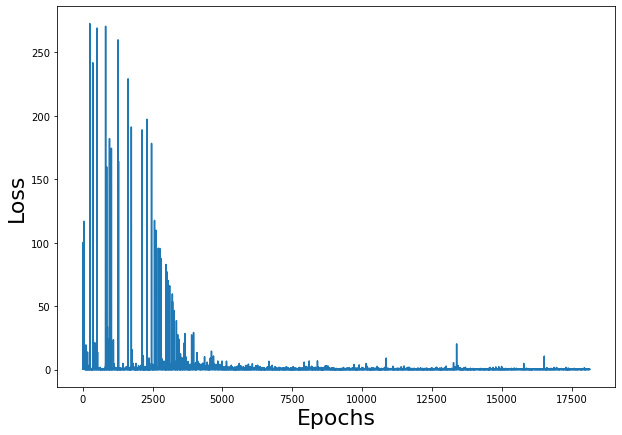

In [11]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

##### PyTorch Automatic Differentiation Review

In [12]:
#https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m + b#@ x + b
    return y

In [32]:
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [33]:
y.grad_fn

In [34]:
y.backward()

In [35]:
m.grad

tensor([2.])

##### Listing 3.4

In [17]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [18]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

##### Listing 3.5

In [33]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [34]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values we want the DQN to learn
#O If game is over, reset status and mov number

4999 0.06030523404479027


In [35]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

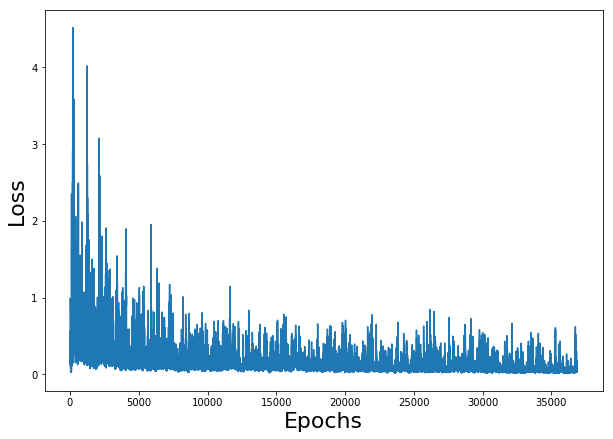

In [36]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [37]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 927
Win percentage: 92.7%


In [14]:
test_model(model, mode='random')

Initial State:
[['P' ' ' ' ' '-']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' 'P' ' ' '-']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' 'P' '-']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' '-']
 [' ' 'W' 'P' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' '-']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

###### Listing 3.7

In [83]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [93]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #A
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

2999 0.02813359536230564


Text(0, 0.5, 'Loss')

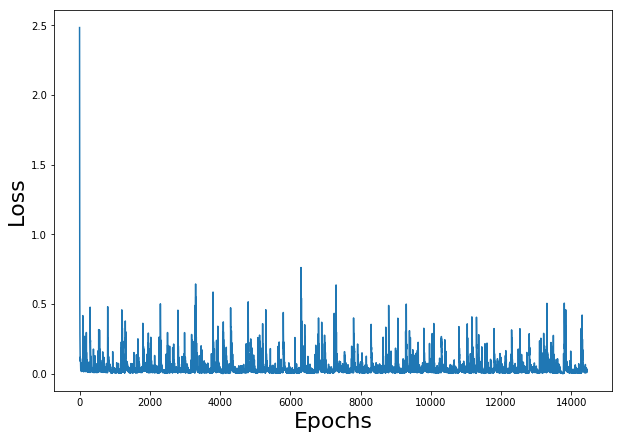

In [94]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [108]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 942
Win percentage: 94.19999999999999%
